# Laser Scan Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
pd_response = pd.read_csv('hamamatsu_responsivity.csv')
area = 100 #mm2
amps_per_watt = float(pd_response[pd_response.wavelength == 440].responsivity)

In [3]:
def watts_per_mm2(amps):  
    watts_per_mm2 = (amps/amps_per_watt)/area
    return watts_per_mm2

In [4]:
def watts_per_cm2(amps):  
    watts_per_cm2 = (amps/amps_per_watt)/1.
    return watts_per_cm2

In [5]:
data_path = '/home/parfa30/DATA/ScanData'
scan_450nm = os.path.join(data_path,'450nm_laser_center_scan_042222_1.csv')
scan_450nm_stability = os.path.join(data_path, '450nm_laser_stability.csv')

scan_600nm = os.path.join(data_path,'600nm_laser_center_scan_042222.csv')
scan_600nm = os.path.join(data_path,'600nm_laser_center_scan_slow_2022-04-27T16:42:30.275.csv')
scan_600nm_stability = os.path.join(data_path, '600nm_laser_stability_center_2022-04-27T16:56:59.546.csv')


scanfull_450nm = os.path.join(data_path,'450nm_full_scan_21x21_2022-04-28T18:17:48.133.csv')
scanfull_600nm = os.path.join(data_path,'600nm_full_scan_21x21_2022-04-28T04:11:19.928.csv')
scanfull_600nm_stability = os.path.join(data_path,'600nm_laser_stability.csv')

In [6]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [7]:
def get_stability_data(filen):
    stability_file = os.path.join(data_path,filen)
    data_stab = pd.read_csv(stability_file)
    times = [x.to_julian_date() for x in pd.to_datetime(data_stab['Start'])]
    data_stab['jd_time'] = times
    y = list(data_stab['mean'])
    f = interpolate.interp1d(times, y, fill_value="extrapolate", bounds_error=False)
    mean_val = np.mean(data_stab['mean'])
    return f, mean_val, data_stab

def adjusted_output(jd_time, output_val, f_, mean_val):
    b = (f_(jd_time)-mean_val)/mean_val
    x = 1/((b+1)/output_val)
    return x

def get_adjusted_data(filen_data, filen_stability):
    data_df = pd.read_csv(filen_data)
    data_df['julian_time'] = [x.to_julian_date() for x in pd.to_datetime(data_df['Start'])]
    f, mean_val, data_stab = get_stability_data(filen_stability)
    data_df['adjusted_mean'] = adjusted_output(data_df['julian_time'], data_df['mean'], f, mean_val)
    return data_df, data_stab

In [8]:
data_450nm, data_450nm_stability = get_adjusted_data(scan_450nm, scan_450nm_stability)

In [9]:
xdata = np.array(data_450nm.X)
ydata = np.array(data_450nm['adjusted_mean'])
H, A, x0, sigma = gauss_fit(xdata,ydata)

Text(0.5, 0.98, '450nm Center Scan')

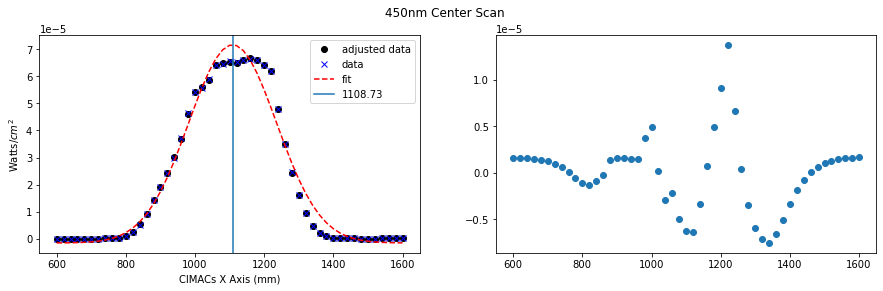

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.plot(xdata, ydata, 'ko', label='adjusted data')
ax1.plot(xdata, data_450nm['mean'], 'bx', label='data')
ax1.plot(xdata, gauss(xdata, *gauss_fit(xdata, ydata)), '--r', label='fit')
ax1.axvline(x0, label='{:.2f}'.format(x0))
ax1.legend()
ax1.set_xlabel('CIMACs X Axis (mm)')
ax1.set_ylabel("Watts$/cm^{2}$")

ax2.scatter(xdata, ydata - gauss(xdata, *gauss_fit(xdata, ydata)))

fig.suptitle('450nm Center Scan')

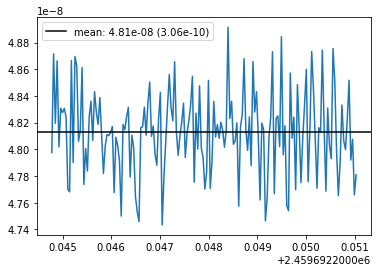

In [49]:
plt.plot(data_450nm_stability.jd_time, data_450nm_stability['mean'])
plt.axhline(np.mean(data_450nm_stability['mean']), color='black',label='mean: {:.2e} ({:.2e})'.format(np.mean(data_450nm_stability['mean']),np.std(data_450nm_stability['mean'])))
plt.legend()

In [50]:
data_600nm, data_600nm_stability = get_adjusted_data(scan_600nm, scan_600nm_stability)

In [51]:
xdata = np.array(data_600nm.julian_time)
ydata = np.array(data_600nm['adjusted_mean'])
H, A, x0, sigma = gauss_fit(xdata,ydata)

Text(0.5, 0.98, '600nm Center Scan')

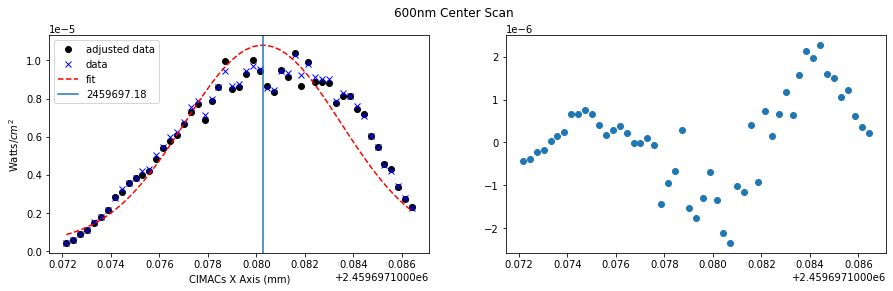

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.plot(xdata, ydata, 'ko', label='adjusted data')
ax1.plot(xdata, data_600nm['mean'], 'bx', label='data')
ax1.plot(xdata, gauss(xdata, *gauss_fit(xdata, ydata)), '--r', label='fit')
ax1.axvline(x0, label='{:.2f}'.format(x0))
ax1.legend()
ax1.set_xlabel('CIMACs X Axis (mm)')
ax1.set_ylabel("Watts$/cm^{2}$")

ax2.scatter(xdata, ydata - gauss(xdata, *gauss_fit(xdata, ydata)))

fig.suptitle('600nm Center Scan')

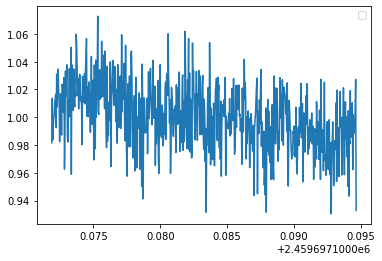

In [53]:
plt.plot(data_600nm_stability.jd_time, data_600nm_stability['mean']/np.mean(data_600nm_stability['mean']))
#plt.axhline(np.mean(data_600nm_stability['mean']), color='black',label='mean: {:.2e} ({:.2e})'.format(np.mean(data_600nm_stability['mean']),np.std(data_600nm_stability['mean'])))
plt.legend()

In [11]:
data_600nm_full, data_600nm_full_stability = get_adjusted_data(scanfull_600nm, scanfull_600nm_stability)

In [12]:
data_450nm_full = pd.read_csv(scanfull_450nm)
data_600nm_full = pd.read_csv(scanfull_600nm)

In [13]:
X = data_600nm_full.X
Y = data_600nm_full.Y

In [14]:
# Define scan area
start_x_loc = 700
end_x_loc = 1500
start_y_loc = 300
end_y_loc = 1100
num_steps_x = 20
num_steps_y = 20
steps_x = np.linspace(start_x_loc, end_x_loc, num_steps_x + 1)
steps_y1 = np.linspace(start_y_loc, end_y_loc, num_steps_y + 1)
steps_y2 = np.linspace(end_y_loc, start_y_loc, num_steps_y + 1)

In [15]:
y = np.hstack([steps_y1,steps_y2])

In [16]:
yy = np.hstack([y,y,y,y,y,y,y,y,y,y,steps_y1])

In [17]:
Y = yy

In [18]:
data_600nm_full['Y'] = yy

In [19]:
Z = watts_per_mm2(data_600nm_full['mean'])

In [20]:
np.std(Z)

7.585710148139362e-08

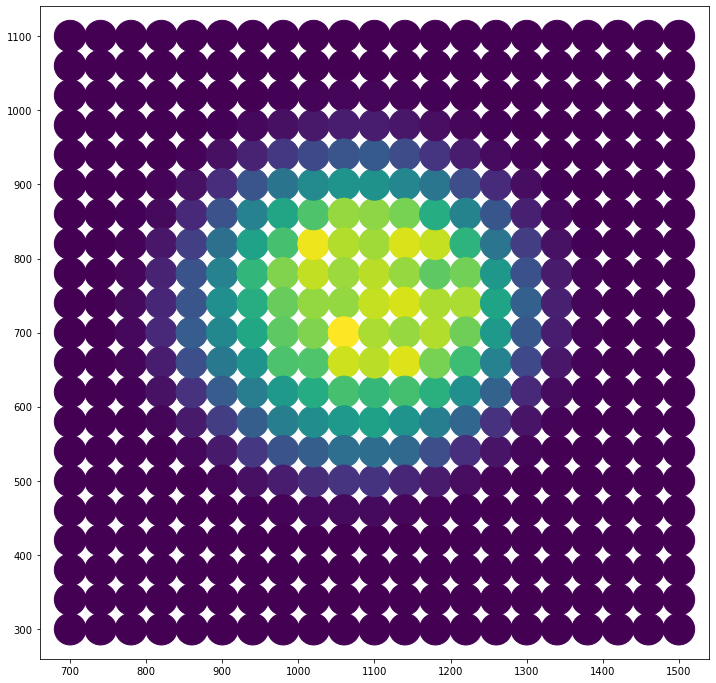

In [21]:
plt.figure(figsize=(12,12))
plt.scatter(X,Y,c=Z,s=1000)

In [22]:
center_x = data_600nm_full[data_600nm_full.Y == 700]
center_y = data_600nm_full[data_600nm_full.X==1100]

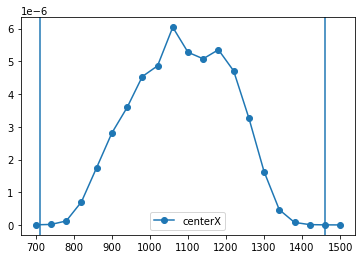

In [23]:
plt.plot(center_x.X, center_x['mean'],'o-',label='centerX')
plt.axvline(1086-(750/2.))
plt.axvline(1086+(750/2.))
#plt.plot(center_y.Y-711, center_y['mean'],'o-',label='centerY')
plt.legend()

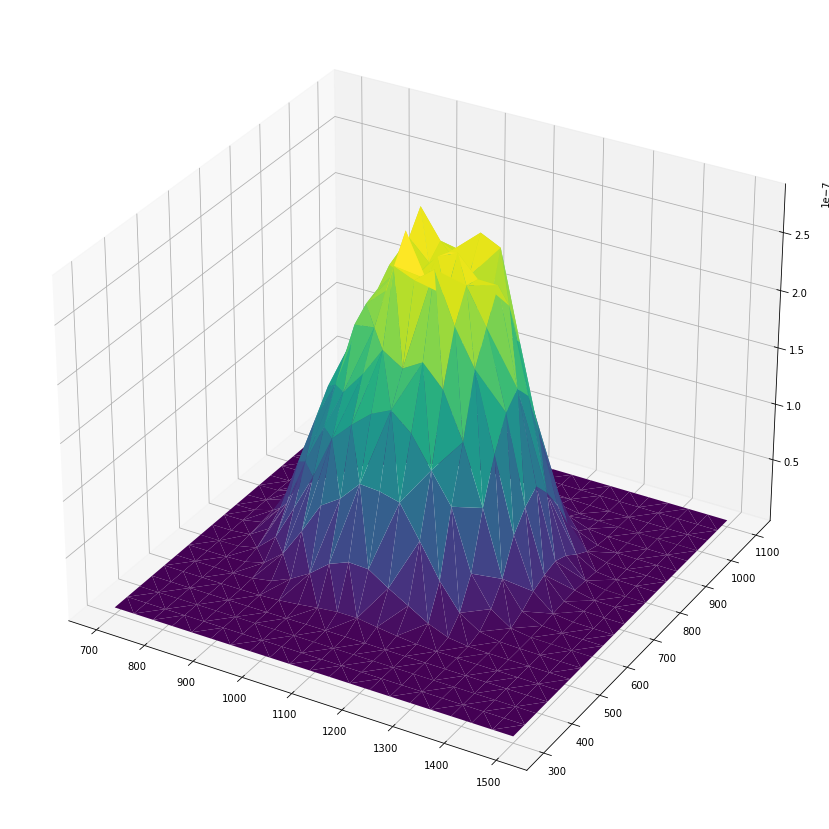

In [24]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.plot_trisurf(X,Y ,Z,cmap = 'viridis')
# rotate the axes and update
#ax.view_init(10,900)

In [25]:
from scipy import interpolate

In [26]:
f = interpolate.interp2d(X, Y, Z, kind='quintic')
xnew = np.linspace(700,1500,100)
ynew = np.linspace(300, 1100,100)
znew = f(xnew, ynew)

In [27]:
xx, yy = np.meshgrid(xnew, ynew)
xx = xx - 1086
yy = yy - 711

In [28]:
xx.flatten().shape

(10000,)

In [29]:
data = np.vstack([xx.flatten(), yy.flatten(), znew.flatten()]).T

In [30]:
df = pd.DataFrame(data, columns = ['X','Y','Power (W/mm2)'])

In [101]:
df.to_csv('600nm_laser_output.csv', index=False)

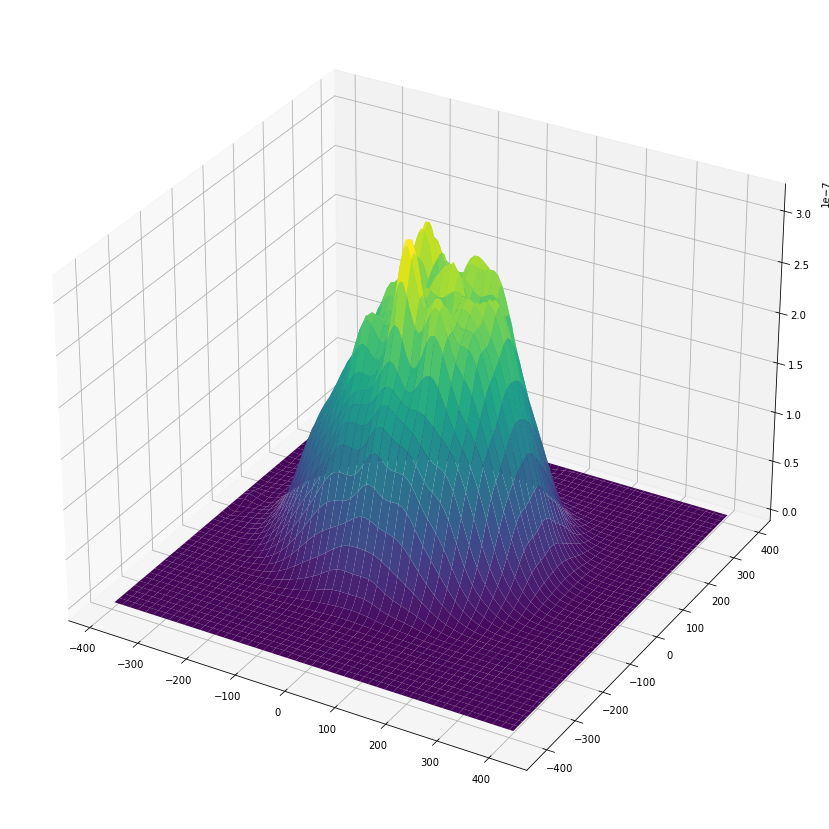

In [31]:
xx, yy = np.meshgrid(xnew, ynew)
xx = xx - 1086
yy = yy - 711
plt.figure(figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.plot_surface(xx, yy, znew,cmap = 'viridis')

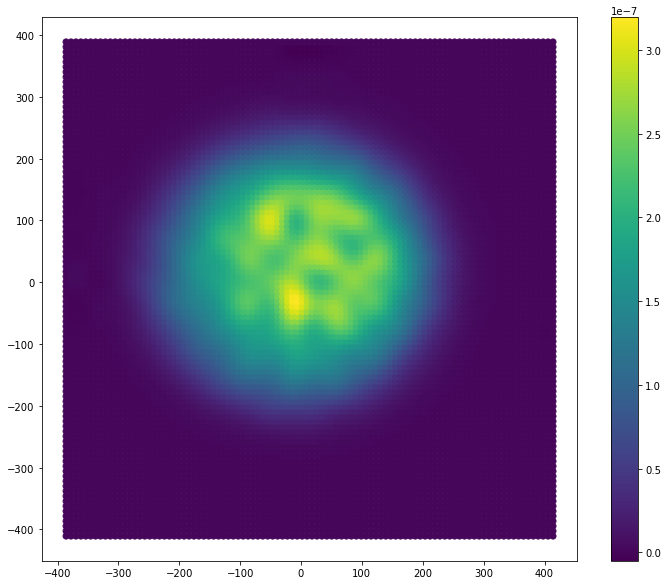

In [35]:
plt.figure(figsize=(12,10))
plt.scatter(df.X, df.Y, c= df["Power (W/mm2)"])
plt.colorbar()

In [41]:
y_only = df[np.abs(df.X) < 2]
x_only = df[np.abs(df.Y) < 2]

In [52]:
new_df = pd.DataFrame()

In [58]:
new_df['Y'] = list(y_only['Y'])
new_df['Y_Pwr'] = list(y_only['Power (W/mm2)'])
new_df['X'] = list(x_only['X'])
new_df['X_Pwr'] = list(x_only['Power (W/mm2)'])

In [61]:
new_df.to_csv('600nm_center.csv',index=False)

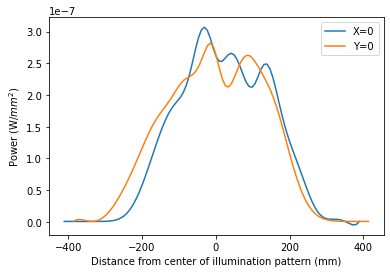

In [46]:
plt.plot(y_only.Y, y_only['Power (W/mm2)'], label='X=0')
plt.plot(x_only.X, x_only['Power (W/mm2)'], label='Y=0')
plt.ylabel("Power (W/$mm^{2}$)")
plt.xlabel('Distance from center of illumination pattern (mm)')
plt.legend()

In [34]:
from scipy.interpolate import RegularGridInterpolator

V = np.zeros((len(X),len(Y),len(Z)))
for i in range(len(X)):
    for j in range(len(Y)):
        for k in range(len(Z)):
            V[i,j,k] = 100*X[i] + 10*Y[j] + Z[k]


In [35]:
fn = RegularGridInterpolator((X,Y,Z), V)

ValueError: The points in dimension 0 must be strictly ascending

In [ ]:
fn(np.array([xnew, ynew]))

ValueError: input operand has more dimensions than allowed by the axis remapping

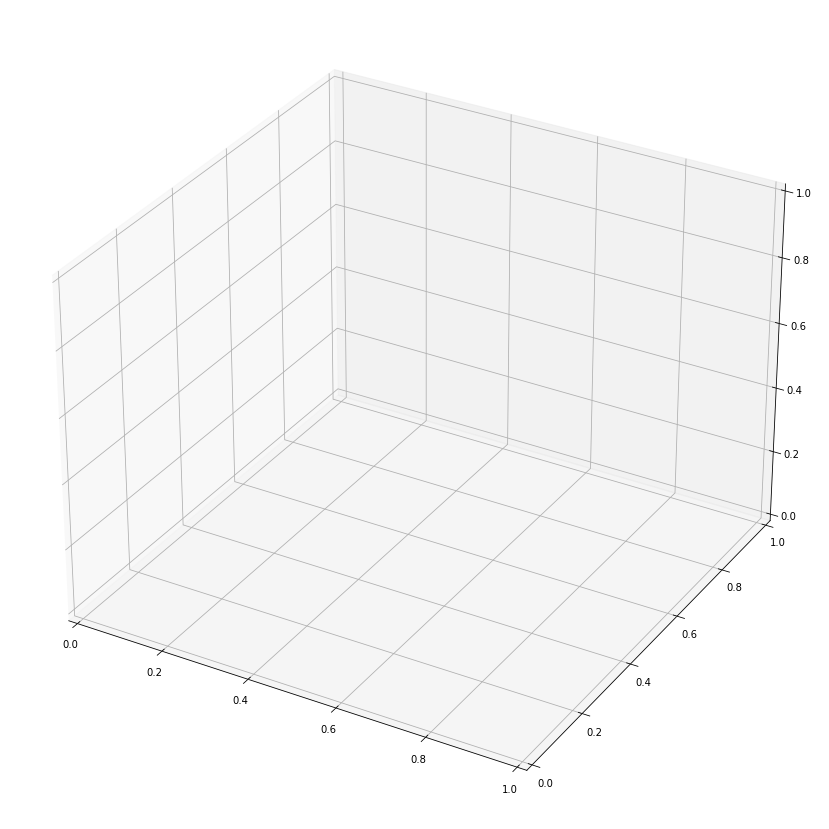

In [28]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.plot3D(xnew, ynew, znew)

In [27]:
X = data_450nm_full.X
Y = data_450nm_full.Y
Z = data_450nm_full['mean']

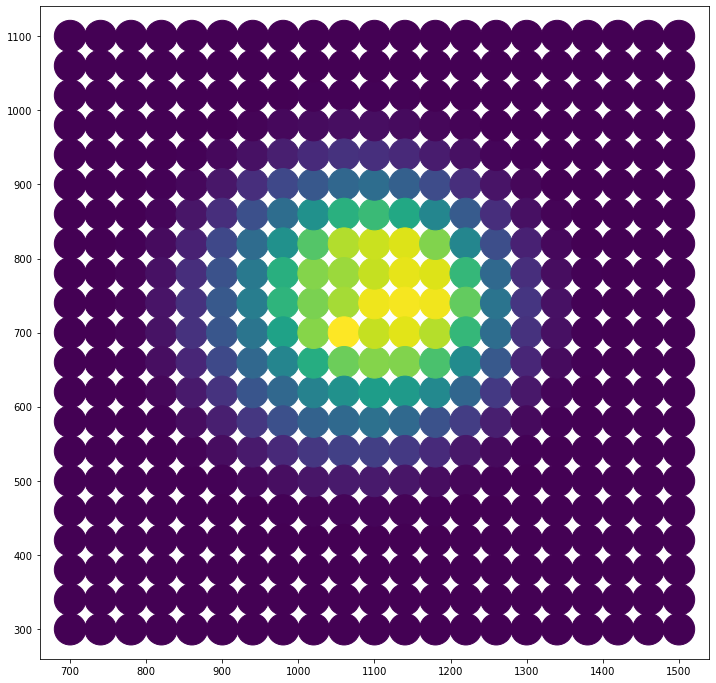

In [28]:
plt.figure(figsize=(12,12))
plt.scatter(X,Y,c=Z,s=1000)

In [29]:
center_x = data_450nm_full[data_450nm_full.Y == 700]
center_y = data_450nm_full[data_450nm_full.X==1100]

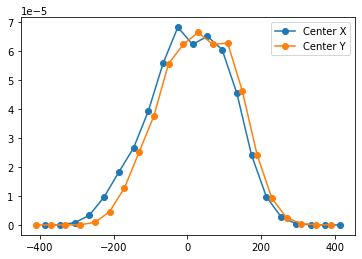

In [31]:
plt.plot(center_x.X-1086, center_x['mean'],'o-',label='Center X')
plt.plot(center_y.Y-711, center_y['mean'],'o-', label='Center Y')
plt.legend()

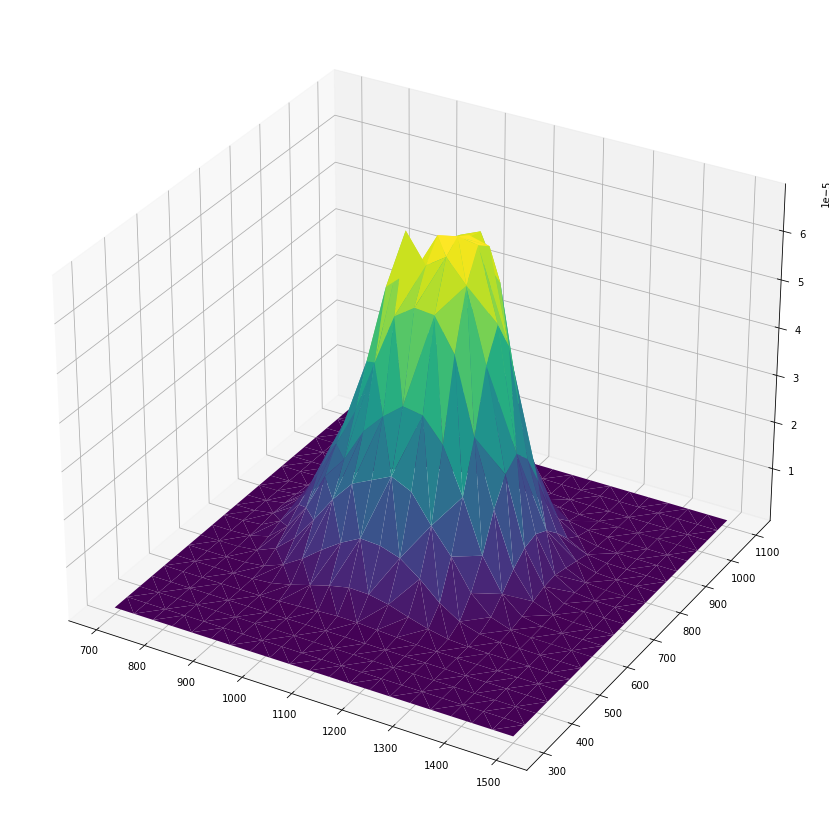

In [32]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.plot_trisurf(X,Y ,Z,cmap = 'viridis')
# rotate the axes and update
#ax.view_init(10,900)

In [64]:
stability_fiber = os.path.join(data_path,'600nm_center_laser_stability_2022-04-27T21:18:04.284.csv')
stability_laser = os.path.join(data_path, '600nm_stability_center_laser_stability_2022-04-27T21:20:08.655.csv')
stab_df = pd.read_csv(stability_fiber)
stab_df1 = pd.read_csv(stability_laser)

In [65]:
stab_df['jd'] = [x.to_julian_date() for x in pd.to_datetime(stab_df['Start'])]
stab_df1['jd'] = [x.to_julian_date() for x in pd.to_datetime(stab_df1['Start'])]

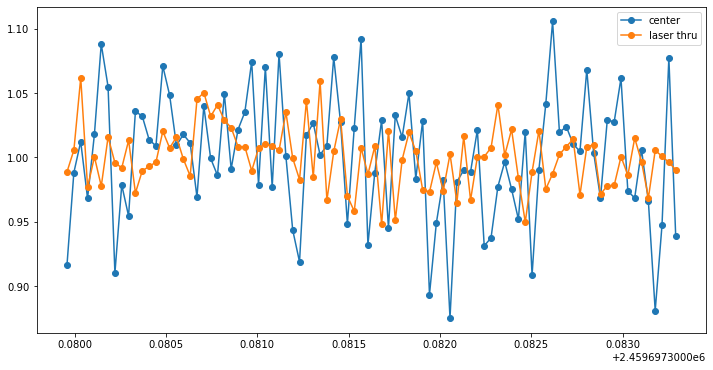

In [67]:
plt.figure(figsize=(12,6))
plt.plot(stab_df['jd'], stab_df['mean']/np.mean(stab_df['mean']),'o-',label='center')
plt.plot(stab_df1['jd'], stab_df1['mean']/np.mean(stab_df1['mean']),'o-',label='laser thru')
plt.legend()

In [57]:
stability_fiber = os.path.join(data_path,'600nm_center_laser_stability_floor_2022-04-27T21:36:02.799.csv')
stability_laser = os.path.join(data_path, '600nm_stab_center_laser_stability_floor_2022-04-27T21:38:11.973.csv')
stab_df = pd.read_csv(stability_fiber)
stab_df1 = pd.read_csv(stability_laser)

In [58]:
stab_df['jd'] = [x.to_julian_date() for x in pd.to_datetime(stab_df['Start'])]
stab_df1['jd'] = [x.to_julian_date() for x in pd.to_datetime(stab_df1['Start'])]

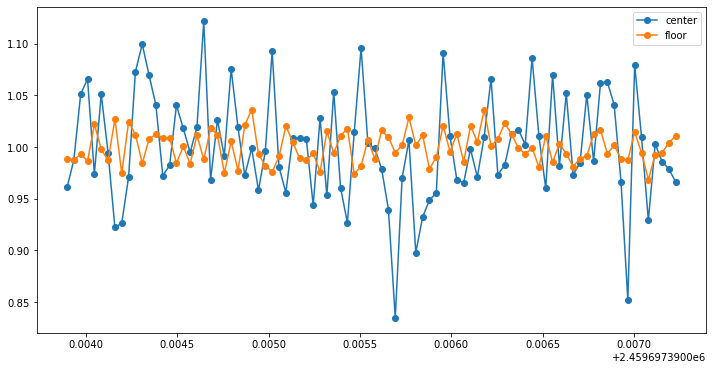

In [63]:
plt.figure(figsize=(12,6))
plt.plot(stab_df['jd'], stab_df['mean']/np.mean(stab_df['mean']),'o-',label='center')
plt.plot(stab_df1['jd'], stab_df1['mean']/np.mean(stab_df1['mean']),'o-',label='floor')
plt.legend()

In [69]:
np.mean(stab_df['mean'])

6.826944444444446e-06

In [70]:
np.mean(stab_df1['mean'])

1.4476109876543215e-08